In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github')))
sys.path.append(os.path.abspath(os.path.join('/home/yzwang/MF/github/Method')))
import numpy as np
import torch
import torch.nn as nn
from datetime import datetime
from utils import (root_mean_squared_error, mean_absolute_error, create_lagged_data, three_frequency_convert_to_lowest, plot_forecasts_multi)
from Baseline import set_seed
set_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#data parameters
d1 = 20
d2 = 3
P1 = 13
P2 = 56
QP3 = 9
Q = 5
DD = d1*d2*P1+ d2*P2+ QP3

# Model architecture (RNN with linear projection)
class RNN1(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=9):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim) 
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        # rnn_out = self.dropout(rnn_out)
        return self.fc(rnn_out)

Pre-COVID

In [2]:
T = 188
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print('Y shape:', Y.shape)
print('X_M shape:', X_M.shape)
print('X_H shape:', X_H.shape)
print('Y max:', np.max(Y), 'Y min:', np.min(Y), 'Y mean:', np.mean(Y), 'Y std:', np.std(Y))
print('X_M max:', np.max(X_M), 'X_M min:', np.min(X_M), 'X_M mean:', np.mean(X_M), 'X_M std:', np.std(X_M))
print('X_H max:', np.max(X_H), 'X_H min:', np.min(X_H), 'X_H mean:', np.mean(X_H), 'X_H std:', np.std(X_H))


T 188 T_H: 11280 T_M: 564
T_train: 148 T_val: 20 T_test: 20
Y shape: (9, 188)
X_M shape: (56, 564)
X_H shape: (13, 11280)
Y max: 9.083060657379114 Y min: -4.5941919722762705 Y mean: 0.003900497296983884 Y std: 0.87206867900193
X_M max: 16.940348022306395 X_M min: -17.12817591268496 X_M mean: 0.00039118324278265517 X_M std: 0.8661968246394718
X_H max: 23.195031218753527 X_H min: -25.564933640672024 X_H mean: 7.850425864522082e-05 X_H std: 0.9699726059297447


Y_total shape: (957, 188)



----- Evaluating Direct Multi-Step Forecasting for Horizon = t+1 -----
==== Step 0
==== Step 1
==== Step 2
==== Step 3
==== Step 4
==== Step 5
==== Step 6
==== Step 7
==== Step 8
==== Step 9
==== Step 10
==== Step 11
==== Step 12
==== Step 13
==== Step 14
==== Step 15
==== Step 16
==== Step 17
==== Step 18
==== Step 19

=== Horizon 1 (Direct Forecast t+1) ===
True matrix:
 [[-1.5160e-01  3.9050e-01 -1.3240e-01 -6.0720e-01 -1.0020e+00]
 [ 2.0880e-01  4.3300e-02  6.4200e-01  2.0940e-01 -4.7580e-01]
 [-4.7700e-02 -2.8100e-02 -1.1320e-01  6.5870e-01  2.1758e+00]
 [-2.4820e-01 -1.3800e-02 -1.5790e-01  1.1720e-01 -9.5280e-01]
 [-4.4600e-01 -2.8300e-01 -3.6160e-01 -8.0000e-04 -8.4650e-01]
 [-8.4200e-02  3.2100e-02 -3.1940e-01  5.8130e-01 -2.1150e-01]
 [-3.2070e-01 -2.0210e-01 -3.1850e-01 -6.1050e-01  2.4701e+00]
 [ 3.4500e-02 -2.1500e-02 -1.0560e-01  5.8000e-03 -1.4170e+00]
 [-1.0720e-01 -1.8430e-01  4.6410e-01 -3.0550e-01  6.3850e-01]
 [-1.6890e-01  4.4700e-02 -2.7860e-01 -8.5230e-01  1.926

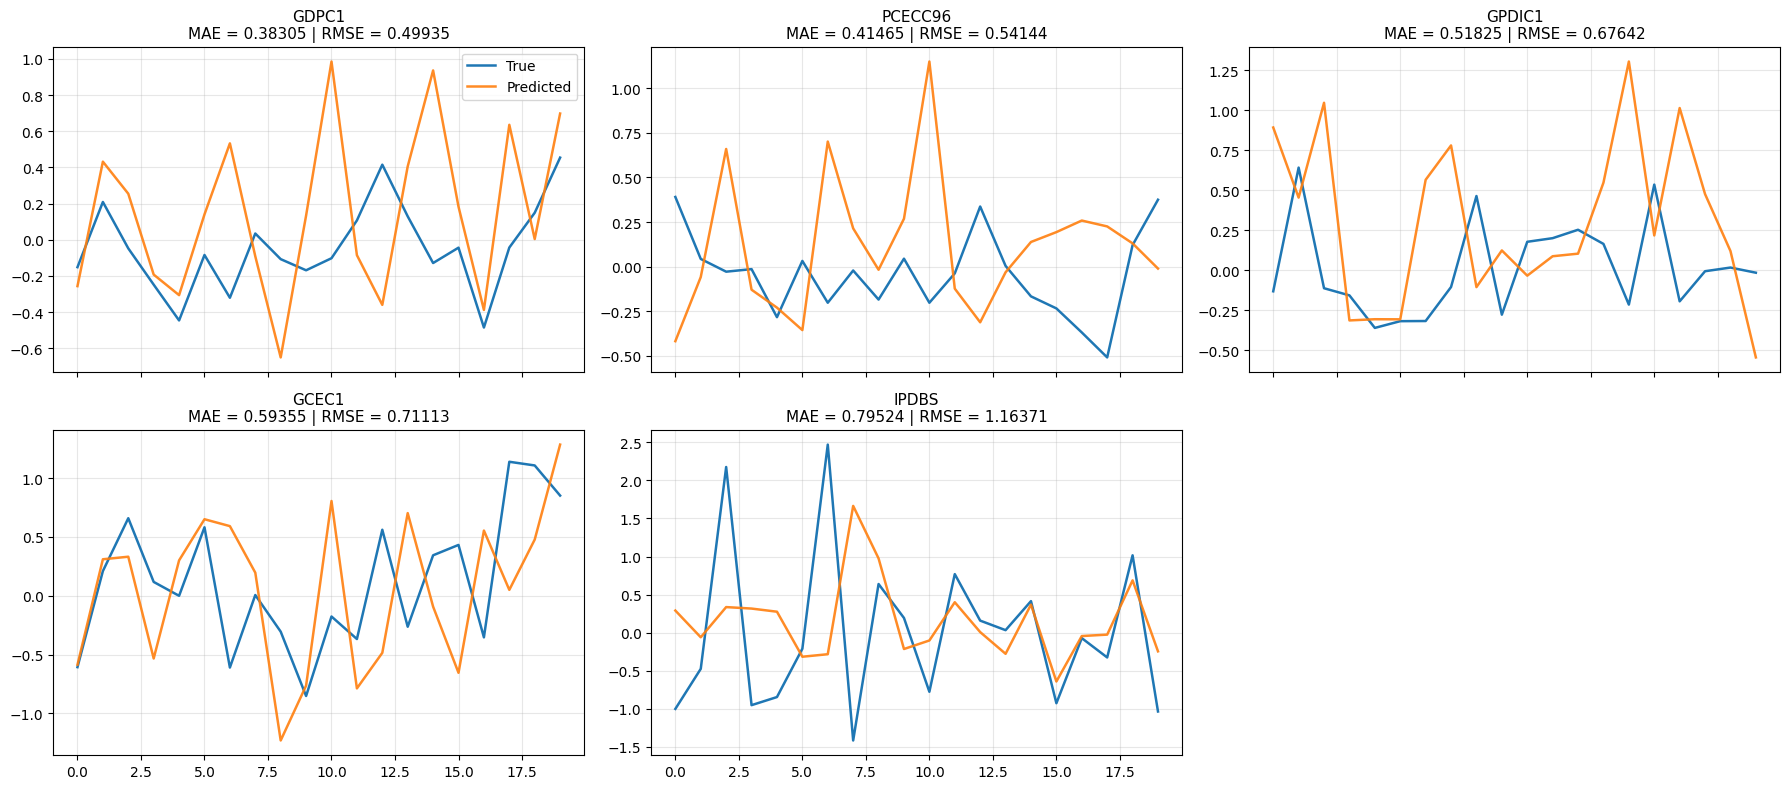


All direct multi-step forecasts and plots saved successfully.


In [3]:
EPOCHS = 100
LEARNING_RATE = 0.001
Hidden_dim = 128
k = 1
eval_horizon = [0]
eval_horizon_len = len(eval_horizon)

Y_total = three_frequency_convert_to_lowest(Y, X_M, X_H, d1, d2)
print('Y_total shape:', Y_total.shape)
model = RNN1(input_dim=DD*k, hidden_dim=Hidden_dim, output_dim=Q).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
forecasts_multi = np.zeros((eval_horizon_len, Q, T_test))
# forecast_test_RNN = np.zeros((Q, T_test)) 
for i in range(eval_horizon_len):
    eval_horizon_curr = eval_horizon[i]
    target_horizon = int(eval_horizon_curr) + 1
    print(f'\n----- Evaluating Direct Multi-Step Forecasting for Horizon = t+{target_horizon} -----')

    for t in range(T_test):
        print(f'==== Step {t}')
        X_train_cur = Y_total[:,:T_train + T_val + t - target_horizon]
        X_train_lag_cur = create_lagged_data(X_train_cur, k)  #(P3*k, T_train + T_val+t-k) #(10,43)
        # print('X_L_train_lagged_cur', X_train_lag_cur.shape)  
        Y_train_cur = Y_total[:Q, k+ target_horizon-1:T_train + T_val + t]  #(P3, T_train + T_val+t-k) #(5,43)
        # print('Y_train_cur', Y_train_cur.shape)
        # print('X_train_lag_cur', X_train_lag_cur.shape)
        # Training phase
        model.train()
        for epoch in range(EPOCHS):
            optimizer.zero_grad()
            y_pred = model(torch.FloatTensor(X_train_lag_cur.T).to(device)).T
            loss = criterion(y_pred, torch.FloatTensor(Y_train_cur).to(device))
            loss.backward()
            optimizer.step()
        X_test_cur = Y_total[:, T_train + T_val + t - k- target_horizon+1:T_train + T_val + t- target_horizon+1].reshape(-1, 1)
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.FloatTensor(X_test_cur.T).unsqueeze(0).to(device)).reshape(-1)  #(P3)
        forecasts_multi[i,:, t] = y_pred.cpu().numpy()

Y_true = Y_total[:Q, T_train + T_val:]
for h in range(eval_horizon_len):
    forecast_test = forecasts_multi[h]      # (Q, T_test - eval_horizon + 1)
    forecast_true = Y_true          # (Q, T_test - eval_horizon + 1)

    err_MAE_t, err_MAE = mean_absolute_error(forecast_true, forecast_test)
    err_RMSE_t, err_RMSE = root_mean_squared_error(forecast_true, forecast_test)

    print(f"\n=== Horizon {h+1} (Direct Forecast t+{h+1}) ===")
    print("True matrix:\n", np.round(forecast_true.T, 4))
    print("Forecast matrix:\n", np.round(forecast_test.T, 4))
    print("\nMAE per series :", np.round(err_MAE_t, 4))
    print("RMSE per series:", np.round(err_RMSE_t, 4))
    print("Overall Mean MAE :", f"{err_MAE:.4f}")
    print("Overall Mean RMSE:", f"{err_RMSE:.4f}")

print(f'\n===================== DIRECT: k={k}, eval_horizon={eval_horizon} =====================')

now = datetime.now()
print('Current time:', now.strftime("%Y_total-%m-%d %H:%M"))

# === Plot forecasts for each horizon ===
for h in range(eval_horizon_len):
    plot_forecasts_multi(
        Y_true, forecasts_multi[h],
        save_path=f'../result/RNN_k{k}_horizon{h+1}.png',
        title_prefix=f'RNN Forecast (Horizon = {h+1})'
    )

print("\nAll direct multi-step forecasts and plots saved successfully.")


Post_COVID

In [4]:
T = 208
T_val = 20
T_test = 20
T_train = T - T_val - T_test

T_M = T * d2
T_H = T * d1 * d2
print('T',T,'T_H:', T_H, 'T_M:', T_M)
print('T_train:', T_train, 'T_val:', T_val, 'T_test:', T_test)

Y = np.load(f'../data_clean/Y_std.npy')[:,:T]
X_M = np.load(f'../data_clean/X_M_std.npy')[:,:T*d2]
X_H = np.load(f'../data_clean/X_H_std.npy')[:,:T*d1*d2]

print('Y shape:', Y.shape)
print('X_M shape:', X_M.shape)
print('X_H shape:', X_H.shape)
print('Y max:', np.max(Y), 'Y min:', np.min(Y), 'Y mean:', np.mean(Y), 'Y std:', np.std(Y))
print('X_M max:', np.max(X_M), 'X_M min:', np.min(X_M), 'X_M mean:', np.mean(X_M), 'X_M std:', np.std(X_M))
print('X_H max:', np.max(X_H), 'X_H min:', np.min(X_H), 'X_H mean:', np.mean(X_H), 'X_H std:', np.std(X_H))


T 208 T_H: 12480 T_M: 624
T_train: 168 T_val: 20 T_test: 20
Y shape: (9, 208)
X_M shape: (56, 624)
X_H shape: (13, 12480)
Y max: 9.083060657379114 Y min: -8.981419418585231 Y mean: -7.591268544445516e-18 Y std: 1.0
X_M max: 24.694614539572694 X_M min: -24.295703738737302 X_M mean: 3.100897642039128e-18 X_M std: 1.0
X_H max: 30.816445727888585 X_H min: -33.0391984692243 X_H mean: -1.25255930983351e-17 X_H std: 1.0000000000000169


In [5]:
EPOCHS = 100
LEARNING_RATE = 0.001
Hidden_dim = 128
k = 1
Y = three_frequency_convert_to_lowest(Y, X_M, X_H, d1, d2)
print('Y shape:', Y.shape)
model = RNN1(input_dim=DD*k, hidden_dim=Hidden_dim, output_dim=Q).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

forecast_test_RNN = np.zeros((Q, T_test)) 
for t in range(T_test):
    print(f'==== Step {t}')
    X_train_cur = Y[:,:T_train + T_val + t -1]
    X_train_lag_cur = create_lagged_data(X_train_cur, k)  #(P3*k, T_train + T_val+t-k) #(10,43)
    # print('X_L_train_lagged_cur', X_train_lag_cur.shape)  
    Y_train_cur = Y[:Q, k:T_train + T_val + t]  #(P3, T_train + T_val+t-k) #(5,43)
    # print('Y_train_cur', Y_train_cur.shape)
    # Training phase
    model.train()
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        y_pred = model(torch.FloatTensor(X_train_lag_cur.T).to(device)).T
        loss = criterion(y_pred, torch.FloatTensor(Y_train_cur).to(device))
        loss.backward()
        optimizer.step()
    X_test_cur = Y[:, T_train + T_val + t - k:T_train + T_val + t].reshape(-1, 1)
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.FloatTensor(X_test_cur.T).unsqueeze(0).to(device)).reshape(-1)  #(P3)
    forecast_test_RNN[:, t] = y_pred.cpu().numpy()

Y_test = Y[:Q, T_train + T_val:]
err_MAFE_t_RNN, err_MAFE_RNN = mean_absolute_error(Y_test, forecast_test_RNN)
err_t_RNN, err_RNN = root_mean_squared_error(Y_test, forecast_test_RNN)
print("\n=== RNN Results ===")
print("True matrix:", Y_test.T)
print('forecast matrix:', np.round(forecast_test_RNN.T,4))
print("\nMAFE:", err_MAFE_t_RNN)
print("RMSFE:", err_t_RNN)
print("Mean MAFE:", err_MAFE_RNN)
print("Mean RMSFE:", err_RNN) 

Y shape: (957, 208)
==== Step 0


==== Step 1
==== Step 2
==== Step 3
==== Step 4
==== Step 5
==== Step 6
==== Step 7
==== Step 8
==== Step 9
==== Step 10
==== Step 11
==== Step 12
==== Step 13
==== Step 14
==== Step 15
==== Step 16
==== Step 17
==== Step 18
==== Step 19

=== RNN Results ===
True matrix: [[ 9.35299674e-03 -5.73500062e-02 -5.37466604e-01  4.53523986e-01
  -6.90598153e-02]
 [-1.90467483e+00 -2.20816306e+00 -8.59470962e-01  7.86579180e-01
  -8.61880784e-02]
 [-8.19074112e+00 -8.98141942e+00 -3.94762545e+00  2.05825258e+00
  -3.36392389e+00]
 [ 6.31581678e+00  7.19688935e+00  4.02044130e+00 -2.39049351e+00
   6.01634051e+00]
 [ 3.76494454e-01  6.23911998e-01  5.49274968e-01 -9.81139316e-01
  -1.24411281e+00]
 [ 6.44838192e-01  1.40706160e+00 -3.64888751e-01  1.02050197e+00
   2.31995032e+00]
 [ 8.16859588e-01  2.35007443e+00 -6.21447463e-01 -1.81818875e+00
   6.18844696e-01]
 [ 1.65349660e-01  5.30525958e-02  7.30768160e-01 -9.84265177e-01
  -3.97239167e-01]
 [ 1.02763318e+00  3.34097267e-01  1.34412833e+0